### When a batter hits a fly ball..
the runner on base only has a few seconds to decide if they want to tag up or not.

I am setting out to create a model that scores each runner on their tag up rate.

A perfect score for a runner will be when the model predicts there should be a run, and the runner scores. If they score when the model doesn't predict a score, this will boost their rating. And of course their score will simply be lowered if their is a predicted run but the player does not score.

In [266]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import StandardScaler

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import sys, threading

sys.setrecursionlimit(10**7) # max depth of recursion
threading.stack_size(2**27)

134217728

In [267]:
#Runners are all on third
#And
#Fly Ball Outs

data = pd.read_csv('royals_project_dataset.csv')
pd.set_option('display.max_columns', 400)

#Quick peek at the data
data.head()

,fielder_pos,inning,batting_run_differential,outs_on_play,runs_on_play,throw,exchange,throw_dist,time_to_catch,ball_vx_0,ball_vz_0,ball_vy_0,ball_v_0,ball_ax_0,ball_az_0,ball_ay_0,ball_apex_x,ball_apex_y,ball_apex_z,player_px_7_0,player_py_7_0,player_px_8_0,player_py_8_0,player_px_9_0,player_py_9_0,landing_location_x,landing_location_y,launch_angle,launch_direction,launch_speed,runner_season_top_velo,runner_id,fielder_id,fielding_team_id,hitting_team_id,play_id
0,8,3,-1,0,0,87.880,1.879,179.059,2.800,6.78772,25.26944,89.94367,93.67220,0.97379,-22.38001,-23.37335,20.30198,154.55036,29.07879,-124.915,268.383,20.725,306.246,156.964,247.989,58.67898,280.93015,15.77588,4.19214,94.73694,6.125,1,212,26,18,1
1,9,3,1,0,1,72.619,0.901,171.262,5.739,12.52199,55.22027,76.91811,95.51164,1.20653,-20.20171,-37.69940,48.64890,203.38019,111.52706,-127.998,275.391,18.102,311.225,148.451,261.408,96.60028,345.01407,35.18650,9.06622,97.35416,7.610,1,226,22,18,2
2,8,3,-2,0,0,84.538,1.000,170.335,5.806,-0.72926,63.24802,60.09668,87.24939,-0.67352,-27.31559,-35.17692,-11.10200,155.93892,124.95093,-142.715,251.029,5.463,327.319,128.432,280.118,-31.66954,262.70143,47.60176,-0.26278,87.53115,7.610,1,68,1,18,3
3,8,3,3,0,1,73.034,NaN,157.046,3.800,6.64741,32.51786,97.17252,102.68446,1.28469,-20.34781,-29.28107,29.35443,217.12133,48.88981,-131.147,264.438,16.239,314.714,132.706,251.642,72.95618,365.52112,17.90542,3.57397,103.29302,8.790,2,187,20,17,4
4,7,1,3,0,1,69.015,1.399,149.091,3.800,-30.14105,37.28200,76.39030,90.18818,1.05194,-23.00382,-28.87653,-74.15648,170.39743,54.35086,-138.812,266.322,15.037,309.355,123.190,246.867,-131.77686,299.29735,24.12366,-21.17599,91.44045,8.790,2,116,29,17,5


In [268]:
#Lets see what is missing
data.isna().sum()

fielder_pos                    0
inning                         0
batting_run_differential       0
outs_on_play                   0
runs_on_play                   0
throw                       2675
exchange                     725
throw_dist                   606
time_to_catch                 24
ball_vx_0                    110
ball_vz_0                    110
ball_vy_0                    110
ball_v_0                     112
ball_ax_0                    110
ball_az_0                    110
ball_ay_0                    110
ball_apex_x                  107
ball_apex_y                  107
ball_apex_z                  107
player_px_7_0               1856
player_py_7_0               1856
player_px_8_0               1856
player_py_8_0               1856
player_px_9_0               1856
player_py_9_0               1856
landing_location_x           107
landing_location_y           107
launch_angle                 107
launch_direction             107
launch_speed                 107
runner_sea

In [269]:
#It looks like throw, exchange, throw_dist, and time_to_catch randomly have some sporactic missing values
#But, everything else looks like it is grouped together

missing = data[data['ball_apex_z'].isna()]
missing[missing.columns[9:29]].head(7)

,ball_vx_0,ball_vz_0,ball_vy_0,ball_v_0,ball_ax_0,ball_az_0,ball_ay_0,ball_apex_x,ball_apex_y,ball_apex_z,player_px_7_0,player_py_7_0,player_px_8_0,player_py_8_0,player_px_9_0,player_py_9_0,landing_location_x,landing_location_y,launch_angle,launch_direction
467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
492,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
691,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [282]:
#Yep, so we gotta get rid of these rows that have all these completely missing values
#To do that we have to fix the normal values that are missing, so then we can just drop the rest

imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')

data[['exchange']] = imputer.fit_transform(data[['exchange']])
data[['throw']] = imputer.fit_transform(data[['throw']])
data[['time_to_catch']] = imputer.fit_transform(data[['time_to_catch']])

meanTD = data.throw_dist.mean()
for i, label in enumerate(data.throw_dist):
    if np.isnan(label):
        data.throw_dist[i] = meanTD #for some reason imputer wasnt working for this column

data.head()

,fielder_pos,inning,batting_run_differential,outs_on_play,runs_on_play,throw,exchange,throw_dist,time_to_catch,ball_vx_0,ball_vz_0,ball_vy_0,ball_v_0,ball_ax_0,ball_az_0,ball_ay_0,ball_apex_x,ball_apex_y,ball_apex_z,player_px_7_0,player_py_7_0,player_px_8_0,player_py_8_0,player_px_9_0,player_py_9_0,landing_location_x,landing_location_y,launch_angle,launch_direction,launch_speed,runner_season_top_velo,runner_id,fielder_id,fielding_team_id,hitting_team_id,play_id,y_pred
0,8,3,-1,0,0,87.880,1.879000,179.059,2.800,6.78772,25.26944,89.94367,93.67220,0.97379,-22.38001,-23.37335,20.30198,154.55036,29.07879,-124.915,268.383,20.725,306.246,156.964,247.989,58.67898,280.93015,15.77588,4.19214,94.73694,6.125,1,212,26,18,1,1
1,9,3,1,0,1,72.619,0.901000,171.262,5.739,12.52199,55.22027,76.91811,95.51164,1.20653,-20.20171,-37.69940,48.64890,203.38019,111.52706,-127.998,275.391,18.102,311.225,148.451,261.408,96.60028,345.01407,35.18650,9.06622,97.35416,7.610,1,226,22,18,2,1
2,8,3,-2,0,0,84.538,1.000000,170.335,5.806,-0.72926,63.24802,60.09668,87.24939,-0.67352,-27.31559,-35.17692,-11.10200,155.93892,124.95093,-142.715,251.029,5.463,327.319,128.432,280.118,-31.66954,262.70143,47.60176,-0.26278,87.53115,7.610,1,68,1,18,3,1
3,8,3,3,0,1,73.034,1.336917,157.046,3.800,6.64741,32.51786,97.17252,102.68446,1.28469,-20.34781,-29.28107,29.35443,217.12133,48.88981,-131.147,264.438,16.239,314.714,132.706,251.642,72.95618,365.52112,17.90542,3.57397,103.29302,8.790,2,187,20,17,4,1
4,7,1,3,0,1,69.015,1.399000,149.091,3.800,-30.14105,37.28200,76.39030,90.18818,1.05194,-23.00382,-28.87653,-74.15648,170.39743,54.35086,-138.812,266.322,15.037,309.355,123.190,246.867,-131.77686,299.29735,24.12366,-21.17599,91.44045,8.790,2,116,29,17,5,1


In [272]:
#Making sure we're good to go and can drop this bad missing data
data.isna().sum()

fielder_pos                    0
inning                         0
batting_run_differential       0
outs_on_play                   0
runs_on_play                   0
throw                          0
exchange                       0
throw_dist                     0
time_to_catch                  0
ball_vx_0                    110
ball_vz_0                    110
ball_vy_0                    110
ball_v_0                     112
ball_ax_0                    110
ball_az_0                    110
ball_ay_0                    110
ball_apex_x                  107
ball_apex_y                  107
ball_apex_z                  107
player_px_7_0               1856
player_py_7_0               1856
player_px_8_0               1856
player_py_8_0               1856
player_px_9_0               1856
player_py_9_0               1856
landing_location_x           107
landing_location_y           107
launch_angle                 107
launch_direction             107
launch_speed                 107
runner_sea

In [273]:
#Dropping this bad data
data = data.dropna()

In [274]:
#Splitting data for model
x = data.drop('runs_on_play', axis = 1).values
y = data['runs_on_play'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 40, test_size = .4)

In [275]:
#Make and fit model
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)

knn.score(x_test, y_test)

0.8101960784313725

In [276]:
#KNN sometimes is better with values scaled, lets see
steps = [('scaler', StandardScaler()), ('knn', KNeighborsClassifier())]
pipeline = Pipeline(steps)
knn_scaled = pipeline.fit(x_train, y_train)

knn_N5 = knn_scaled.score(x_test, y_test)
knn_N5

0.8772549019607843

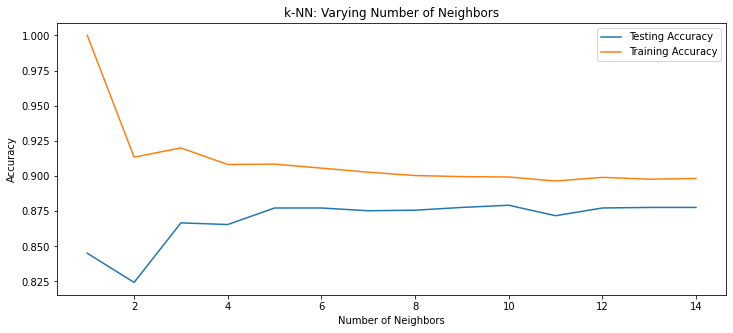

In [277]:
#Much improved after scaling, but lets check to see
#what is the optimal amount of n-neighbors


#this is the n range we willcheck
neighbors = np.arange(1, 15)

#2 arrays size of neighbors so we can append to them
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different amounts of k neighbors
for i, k in enumerate(neighbors):
    
    steps = [('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_neighbors = k))]
    pipeline2 = Pipeline(steps)

    #data on the known and target on the known
    knn2 = pipeline2.fit(x_train, y_train)
    
    # accuracy on the training set
    train_accuracy[i] = knn2.score(x_train, y_train)

    # accuracy on the testing set
    test_accuracy[i] = knn2.score(x_test, y_test)

    
plt.figure(figsize=(12,5))
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

In [278]:
#10 looks like the optimal amount of n-neighbors
steps = [('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_neighbors = 10))]
pipeline = Pipeline(steps)
knn_scaled = pipeline.fit(x_train, y_train)

print('When n-neighbors =  5: ',knn_N5)
print('When n-neighbors = 10: ', knn_scaled.score(x_test, y_test))

#will take any improvement

When n-neighbors =  5:  0.8772549019607843
When n-neighbors = 10:  0.8792156862745099


In [279]:
#Predicting the entire dataset based on model created

y_pred = pipeline.predict(x)

#Adding the predictions as a column to the OG data
data['y_pred'] = y_pred
data.head(3)

,fielder_pos,inning,batting_run_differential,outs_on_play,runs_on_play,throw,exchange,throw_dist,time_to_catch,ball_vx_0,ball_vz_0,ball_vy_0,ball_v_0,ball_ax_0,ball_az_0,ball_ay_0,ball_apex_x,ball_apex_y,ball_apex_z,player_px_7_0,player_py_7_0,player_px_8_0,player_py_8_0,player_px_9_0,player_py_9_0,landing_location_x,landing_location_y,launch_angle,launch_direction,launch_speed,runner_season_top_velo,runner_id,fielder_id,fielding_team_id,hitting_team_id,play_id,y_pred
0,8,3,-1,0,0,87.880,1.879,179.059,2.800,6.78772,25.26944,89.94367,93.67220,0.97379,-22.38001,-23.37335,20.30198,154.55036,29.07879,-124.915,268.383,20.725,306.246,156.964,247.989,58.67898,280.93015,15.77588,4.19214,94.73694,6.125,1,212,26,18,1,1
1,9,3,1,0,1,72.619,0.901,171.262,5.739,12.52199,55.22027,76.91811,95.51164,1.20653,-20.20171,-37.69940,48.64890,203.38019,111.52706,-127.998,275.391,18.102,311.225,148.451,261.408,96.60028,345.01407,35.18650,9.06622,97.35416,7.610,1,226,22,18,2,1
2,8,3,-2,0,0,84.538,1.000,170.335,5.806,-0.72926,63.24802,60.09668,87.24939,-0.67352,-27.31559,-35.17692,-11.10200,155.93892,124.95093,-142.715,251.029,5.463,327.319,128.432,280.118,-31.66954,262.70143,47.60176,-0.26278,87.53115,7.610,1,68,1,18,3,1


In [280]:
#Now we can group together each runner to evaluate them

runners = (
    data.groupby(['runner_id'])
    .agg({'play_id':'count', 'runs_on_play':'sum', 'y_pred':'sum'})
    .reset_index()
    .sort_values(by=['play_id'],ascending=False)
    .reset_index(drop=True)
    )
runners.head()

,runner_id,play_id,runs_on_play,y_pred
0,277,41,37,36
1,196,34,30,28
2,574,34,24,27
3,607,34,22,24
4,500,33,24,28


In [281]:
score = runners['runs_on_play'] / runners['y_pred']
runners['score'] = score
runners.head(15)

,runner_id,play_id,runs_on_play,y_pred,score
0,277,41,37,36,1.027778
1,196,34,30,28,1.071429
2,574,34,24,27,0.888889
3,607,34,22,24,0.916667
4,500,33,24,28,0.857143
5,390,32,28,27,1.037037
6,403,31,27,26,1.038462
7,642,31,29,28,1.035714
8,552,31,23,24,0.958333
9,536,31,28,27,1.037037


### Above, the data is grouped by each runner, with their score.

### Shown is the top 15 runners and their scores. The data is sorted by the count of 'play_id', which is basically the amount of plays for each runner. So as you go down the dataFrame runners have a smaller sample size of how many times they were in a scenario to tag up.